<a href="https://colab.research.google.com/github/NicholasBaraghini/ML4CV_KABLATOR_PRG/blob/main/ML4CV_KABLATOR_prg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT DEPENDENCES

In [1]:
from __future__ import print_function
from __future__ import division

import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import os
import time

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

## Runtime Settings



In [2]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Reproducibility & Deterministic mode


In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

## IMPORT DATASET FROM DRIVE

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'03_-_dichiarazione_persone_fisiche  RISORGIMENTO BARAGHINI (1).rtf.gdoc'
'03_-_dichiarazione_persone_fisiche  RISORGIMENTO BARAGHINI (2).rtf.gdoc'
'03_-_dichiarazione_persone_fisiche  RISORGIMENTO BARAGHINI (3).rtf.gdoc'
'03_-_dichiarazione_persone_fisiche  RISORGIMENTO BARAGHINI.rtf'
'03_-_dichiarazione_persone_fisiche  RISORGIMENTO BARAGHINI.rtf.gdoc'
'4_5829949562042714440 (1).gdoc'
 4_5829949562042714440.gdoc
'4_5836905742614923789 (1).gdoc'
 4_5836905742614923789.gdoc
 4_5899925394022205684.m.gdoc
 4_5908838421824015001.gdoc
'Automazione 3°anno'
 autonomous_driving.zip
 bccd.zip
'Colab Notebooks'
 ContactsBackup_2017.10.10_21:13:39.vcf
'Copia di Final stats Step C.gsheet'
 CUB_200_2011.tgz
'FOUNDATION OF ELECTRONIC (Almatong) '
'Garanzia Risorgimento Baraghini.gdoc'
'IBAN MOTOSPECIAL (1).gdoc'
'IBAN MOTOSPECIAL (2).gdoc'
'IBAN MOTOSPECIAL (3).gdoc'
'IBA

In [5]:
!cp "/content/drive/My Drive/KABLATOR_028.zip" "KABLATOR_028.zip"

In [6]:
!unzip --qq KABLATOR_028.zip -d KABLATOR_028

replace KABLATOR_028/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/test/images/2022-04-16_16-27-32_319412_png.rf.edd2907ad5c8253ae221c4797e2a2922.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/test/images/2022-04-16_16-28-16_619882_png.rf.971e28e95f07dd16809fb7610c22356a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/test/images/2022-04-16_16-28-24_261536_png.rf.9230da17cc9368e93c53d360cb9433f2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/test/images/2022-04-16_16-29-06_864536_png.rf.c6b8d8e7997af2e8c5b89bedecc48db7.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/test/images/2022-04-16_16-29-22_155843_png.rf.8d2ff7c0e8209625007fb291cb55a6d9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace KABLATOR_028/test/images/2022-04

Let's see how files are structured in the different folders:

In [7]:
!ls KABLATOR_028/train/images

2022-04-16_16-27-33_858108_png.rf.9bbbaa86f1594eb5ec3589346ffa4033.jpg
2022-04-16_16-27-33_858108_png.rf.a7a5f9000e3720022f6105f8ed4ab831.jpg
2022-04-16_16-27-33_858108_png.rf.be9b39b705f7650a878aac58dc99eb6d.jpg
2022-04-16_16-27-35_384555_png.rf.059bf7275371c6557af0b12d70116150.jpg
2022-04-16_16-27-35_384555_png.rf.084c795119864af9833ebdf1ce4d7908.jpg
2022-04-16_16-27-35_384555_png.rf.a47f182d641e224e7d5e48a8b7c2e10a.jpg
2022-04-16_16-27-36_896114_png.rf.22534833398fbafe21b922b27d810f4a.jpg
2022-04-16_16-27-36_896114_png.rf.69589390cf072ee90b03b54fb11d7a97.jpg
2022-04-16_16-27-36_896114_png.rf.76f69d6cc3d4b3a1e4795800920b33f0.jpg
2022-04-16_16-27-38_398889_png.rf.2f541902ef606f2890160629fb044c6e.jpg
2022-04-16_16-27-38_398889_png.rf.90380f4f86a90d51715df169ace7a97e.jpg
2022-04-16_16-27-38_398889_png.rf.bf3c1780e28f11163f49f1e70a254341.jpg
2022-04-16_16-27-39_938636_png.rf.38533a26eca8989340502353e4d2f1d6.jpg
2022-04-16_16-27-39_938636_png.rf.8a95d8a3d61df28d5f849a08697047dc.jpg
2022-0

In [8]:
!ls KABLATOR_028/train/labels

2022-04-16_16-27-33_858108_png.rf.9bbbaa86f1594eb5ec3589346ffa4033.txt
2022-04-16_16-27-33_858108_png.rf.a7a5f9000e3720022f6105f8ed4ab831.txt
2022-04-16_16-27-33_858108_png.rf.be9b39b705f7650a878aac58dc99eb6d.txt
2022-04-16_16-27-35_384555_png.rf.059bf7275371c6557af0b12d70116150.txt
2022-04-16_16-27-35_384555_png.rf.084c795119864af9833ebdf1ce4d7908.txt
2022-04-16_16-27-35_384555_png.rf.a47f182d641e224e7d5e48a8b7c2e10a.txt
2022-04-16_16-27-36_896114_png.rf.22534833398fbafe21b922b27d810f4a.txt
2022-04-16_16-27-36_896114_png.rf.69589390cf072ee90b03b54fb11d7a97.txt
2022-04-16_16-27-36_896114_png.rf.76f69d6cc3d4b3a1e4795800920b33f0.txt
2022-04-16_16-27-38_398889_png.rf.2f541902ef606f2890160629fb044c6e.txt
2022-04-16_16-27-38_398889_png.rf.90380f4f86a90d51715df169ace7a97e.txt
2022-04-16_16-27-38_398889_png.rf.bf3c1780e28f11163f49f1e70a254341.txt
2022-04-16_16-27-39_938636_png.rf.38533a26eca8989340502353e4d2f1d6.txt
2022-04-16_16-27-39_938636_png.rf.8a95d8a3d61df28d5f849a08697047dc.txt
2022-0

The function below is an utility function that we have to use to read the file containing the annotations.


In [9]:
def parse_annotations_file(path_to_file: str) -> Tuple[List[str], List[List[float]]]:
    """Parse annotation file generated with the OIDv4 ToolKit.

    Args:
        path_to_file: the path to the file with the annotations.

    Returns:
        The classes for each object in the image.
        The bounding boxes coordinates for each object in the image in 
        [x_min, y_min, x_max, y_max] format, with values between 0 and H and 0 and W.
    """
    with open(path_to_file) as file_annotations:
        obj_classes, boxes  = [], []
        for annotation in file_annotations:            
            category, x_min, y_min, x_max, y_max = annotation.rstrip().split(" ")[-5:]
            obj_classes.append(category)

            try:
                coordinates = [float(x_min), float(y_min), float(x_max), float(y_max)]
            except ValueError:
                print(f'Error in converting float to string for the line {coordinates}')
                raise

            boxes.append(coordinates)
    return obj_classes, boxes

So far we have used an off-the-shelf `Dataset` component but today we need a custom one. The class `torch.utils.data.Dataset` is an abstract class representing a generic dataset. To create our `BCCDDataset`, we have to inherit the `Dataset` class and override two methods:

* `__len__` to get the size of the dataset with `len(dataset)`.
* `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$-th sample.

These two methods are part of the so called *magic* methods. Magic methods in Python are the special methods which are not invoked directly by you, but the invocation happens internally from the class on a certain action. In the case of the `__getitem__(self, index)`, it defines behaviour for when an item is accessed using the notation `self[index]`. In order to distinguish them from *normal* functions, they are surrounded by double underscores.

To convert the data into `torch.Tensor`, we use the API [`torch.as_tensor`](https://pytorch.org/docs/stable/generated/torch.as_tensor.html).

To read the images we can use the [PIL library](https://pillow.readthedocs.io/en/stable/).

Each item returned by the dataset, should follow the implementation of [RetinaNet](https://pytorch.org/vision/master/_modules/torchvision/models/detection/retinanet.html#retinanet_resnet50_fpn).

In [10]:
from torch.utils.data import Dataset

class KABLATORDataset(Dataset):
    def __init__(
        self,
        path_images: str,
        ext_images: str,
        ext_annotations: str,
        transforms: torchvision.transforms = None,
    ) -> None:
        """Init the dataset

        Args:
            path_images: the path to the folder containing the images.
            ext_images: the extension of the images.
            ext_annotations: the extension of the annotations.
            transforms: the transformation to apply to the dataset.
        """
        self.images = sorted([path for path in Path(path_images).rglob(f"*.{ext_images}")])
        self.annotations = sorted(
            [path for path in Path(path_images).rglob(f"*.{ext_annotations}")]
        )
        self.transforms = transforms

        self.classes = ["__background__", "0"]
        if len(self.images) - len(self.annotations) != 0:
            raise AssertionError(
                f"Labels and Images differs in size: {len(self.images)} - {len(self.annotations)}."
            )

    def __getitem__(self, idx):
        path_image = self.images[idx]
        path_annotations = self.annotations[idx]
        image = Image.open(path_image).convert("RGB")
        classes, boxes = parse_annotations_file(path_annotations)

        boxes = [[b[0], b[1], b[2], b[3]] for b in boxes]
        labels = [self.classes.index(c) for c in classes]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.images)

In [11]:
data_transforms = {'train': transforms.Compose([transforms.ToTensor()]),
                      'valid': transforms.Compose([transforms.ToTensor()])}

path_train = os.path.join('KABLATOR_028', 'train')
path_val = os.path.join('KABLATOR_028', 'valid')

data_train = KABLATORDataset(path_images=path_train,
                            ext_images="jpg",
                            ext_annotations="txt",
                            transforms=data_transforms['train'])

data_val = KABLATORDataset(path_images=path_val,
                          ext_images="jpg",
                          ext_annotations="txt",
                          transforms=data_transforms['valid'])

classes = data_train.classes
num_classes = len(classes)

print(f'Samples -> Train = {len(data_train)} - '
      f'Val = {len(data_val)} \n'
      f'Classes = {num_classes}')

Samples -> Train = 415 - Val = 115 
Classes = 2


## Visualization

We need some utilities functions to check if the predicted bounding boxes are correct.

In [12]:
def generate_colors(num_colors: int) -> np.array:
    """Generates an array with RGB triplets representing colors.

    Args:
        num_colors: the number of colors to generate.

    Returns: 
        the generated colors.
    """
    np.random.seed(0)
    colors = np.random.uniform(0, 255, size=(num_colors, 3))
    time_in_ms = 1000 * time.time()
    np.random.seed(int(time_in_ms) % 2 ** 32)

    return colors

We can use functions from the ImageDraw module of [PIL](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html).

In [13]:
def draw_boxes(image: Image,
               boxes: List[List[float]],
               classes: List[str],
               labels: List[int],
               scores: List[float],
               colors: List[List[float]],
               normalized_coordinates: bool,
               add_text: bool = True) -> Image:
    """Draws a rectangle around each object together with the name of the category and the prediction score using a 
    different color for each category.

    Args:
        image: the input image.
        boxes: the bounding boxes in the format [x_min, y_min, x_max, y_max] 
               for all the objects in the image.
        classes: the name of the classes for all the objects in the image.
        labels: the labels for all the objects in the image.
        scores: the predicted scores for all the objects in the image..
        colors: the colors to use for each class of object.
        normalized_coordinates: if true the coordinates are multiplied 
                                according to the height and width of the image.
        add_text: if true add a box with the name of the category and 
                  the score.

    Returns:
        The generated image.
    """
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 30)
    image_with_bb = copy.deepcopy(image)
    painter = ImageDraw.Draw(image_with_bb)

    for i, (box, label) in enumerate(zip(boxes, labels)):        
        color = tuple(colors[label].astype(np.int32))
        x_min, y_min, x_max, y_max = box
        
        if normalized_coordinates:
            width, height = image.size
            x_min *= width
            y_min *= height
            x_max *= width
            y_max *= height

        coord_bb = [x_min, y_min, x_max, y_max]
        painter.rectangle(coord_bb, outline=color, width=4)
        
        if add_text:            
            class_obj = classes[i]
            score = scores[i]
            text_in_box = f'{class_obj}-{score:.2f}'
            text_bottom = y_max
            text_width, text_height = font.getsize(text_in_box)
            margin = np.ceil(0.05 * text_height)
            painter.rectangle([(x_min, text_bottom - text_height - 2 * margin), 
                               (x_min + text_width, text_bottom)], fill=color)
            
            painter.text((x_min + margin, text_bottom - text_height - margin), 
                         text_in_box, fill='black', font=font)

    return image_with_bb

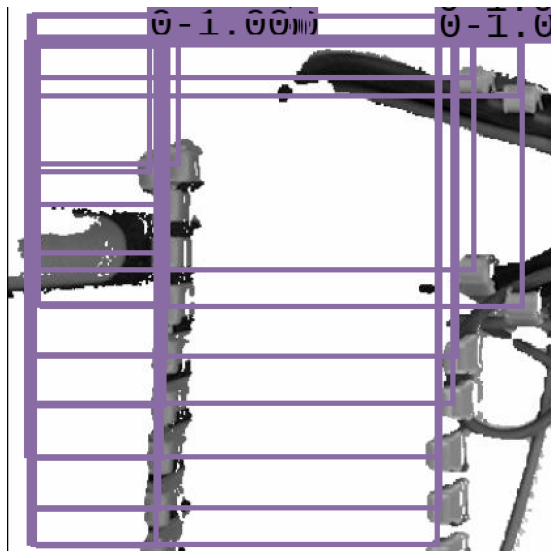

In [15]:
#@title Show KABLATOR Train Dataset { run: "auto", display-mode: "form" }
index_sample = 82  #@param {type:"slider", min:0, max:200, step:1}
colors_mi = generate_colors(num_classes)

image, target = data_train[index_sample]
boxes = target['boxes']
labels = target['labels']
classes = [data_train.classes[l.item()] for l in labels]
image = transforms.ToPILImage()(image)
cell_with_bb = draw_boxes(image,
                          boxes=boxes,
                          classes=classes,
                          labels=labels,
                          scores=[1.0] * len(boxes),
                          colors=colors_mi,
                          normalized_coordinates=True)

plt.figure(figsize=(20, 10))
plt.imshow(cell_with_bb)
plt.axis("off")
plt.show()